In [19]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import chisquare
import torch.nn.functional as F

from model import LDM

In [110]:

class LDMP(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDMP, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        return loss

    def train(self, print=False):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #final_loss = None  # Store the last loss
        epoch_losses = []

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            #final_loss = loss.item()  # Store latest loss value
            epoch_losses.append(loss.item())
            if print: 
                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")

        return epoch_losses #,final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [5]:
def create_holdout(Aij, holdout_ratio=0.1, seed=42):
    Aij_train = Aij.clone()
    if seed is not None:
        random.seed(seed)

    Aij_np = Aij.cpu().numpy()
    pos_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j] > 0]
    neg_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j]==0]

    # select holdtout cases randomly
    n_holdout_pos = int(len(pos_cases)*holdout_ratio)
    n_holdout_neg = int(len(neg_cases)*holdout_ratio)

    holdout_pos = random.sample(pos_cases, n_holdout_pos)
    holdout_neg = random.sample(neg_cases, n_holdout_neg)

    holdouts = holdout_pos + holdout_neg
    random.shuffle(holdouts)
    for i, j in holdouts:
        Aij_train[i,j]=0.0
    return Aij_train, holdouts

In [1]:
class ModelEvaluate:
    def __init__(self, model, Aij_true, test_indices=None):
        self.model = model
        self.Aij_true = Aij_true
        self.test_indices = test_indices

        self.n_drugs, self.n_effects = Aij_true.shape
        self.n_ordinal_classes = Aij_true.max().int().item() +1

    def _get_predictions(self):
        self.model.eval_mode = True
        with torch.no_grad():
            preds, probs = self.model.predict_categories()
            preds_np = preds.cpu().numpy()
            probs_np = probs.cpu().numpy()
        return preds_np, probs_np

    def _get_predictions_bin(self):
        preds_np, _ = self._get_predictions()
        preds_np_bin = np.where(preds_np > 0, 1, 0)
        return preds_np_bin

    def _get_true_values(self):
        Aij_true_np = self.Aij_true.detach().cpu().numpy()
        return Aij_true_np
    
    def _get_true_values_bin(self):
        Aij_np_bin = self._get_true_values()
        Aij_np_bin = np.where(Aij_np_bin > 0, 1, 0)
        return Aij_np_bin

    def _get_true_probs(self):
        Aij_true = self.Aij_true
        n_drugs, n_effects = Aij_true.shape
        n_ordinal_classes = Aij_true.max().int().item() +1
        Aij_true_flat = Aij_true.clone().view(-1)
        Aij_true_flat = F.one_hot(Aij_true_flat.long(), n_ordinal_classes)
        Aij_true_probs = Aij_true_flat.view(n_drugs, n_effects, n_ordinal_classes).permute(2, 0, 1)
        return Aij_true_probs

    def evaluate_binary(self):
        preds_np, _ = self._get_predictions_bin()
        true_np = self._get_true_values_bin()

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true_np[i, j])
                pred_vals.append(preds_np[i, j])
        else:
            for i in range(true_np.shape[0]):
                for j in range(true_np.shape[1]):
                    true_vals.append(true_np[i, j])
                    pred_vals.append(preds_np[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class1(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds1 = np.where(preds == 1, 1, 0)
        true1 = np.where(true == 1, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true1[i, j])
                pred_vals.append(preds1[i, j])
        else:
            for i in range(true1.shape[0]):
                for j in range(true1.shape[1]):
                    true_vals.append(true1[i, j])
                    pred_vals.append(preds1[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def evaluate_class2(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds2 = np.where(preds == 2, 1, 0)
        true2 = np.where(true == 2, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true2[i, j])
                pred_vals.append(preds2[i, j])
        else:
            for i in range(true2.shape[0]):
                for j in range(true2.shape[1]):
                    true_vals.append(true2[i, j])
                    pred_vals.append(preds2[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class3(self):
        preds, _ = self._get_predictions()
        true = self._get_true_values()
        preds3 = np.where(preds == 3, 1, 0)
        true3 = np.where(true == 3, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true3[i, j])
                pred_vals.append(preds3[i, j])
        else:
            for i in range(true3.shape[0]):
                for j in range(true3.shape[1]):
                    true_vals.append(true3[i, j])
                    pred_vals.append(preds3[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def NMI_basic(self):
        Aij_pred, _ = self._get_predictions()
        Aij_true = self._get_true_values()
        #compute edges
        edges = torch.nonzero(torch.tensor(Aij_true) >= 0, as_tuple=False)

        true_labels = []
        pred_labels = []
        for i, j in edges:
            true_labels.append(Aij_true[i,j])
            pred_labels.append(Aij_pred[i,j])
        
        #P(c|c')
        #joint distribution (when are entries in Aij_true and Aij_pred equal)
        n_classes = int(Aij_true.max().item()+1)
        joint_counts = np.zeros((n_classes, n_classes))

        for c, c_mark in zip(true_labels, pred_labels):
            joint_counts[int(c), int(c_mark)] += 1
        joint_probs = joint_counts/ joint_counts.sum()

        #P(c) and P(c')
        p_c = np.sum(joint_probs, axis=1)
        p_c_mark = np.sum(joint_probs, axis=0)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark *np.log(p_c_mark + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(n_classes):
            for c_mark in range(n_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
    
        return NMI, joint_probs
    
    def NMI_advanced(self):
        """ 
        Should run two models e.g one with holdout and one without. Input is the probabilities of each entry being in each class (e.i. the probit matrix)
        """
        _, probs = self._get_predictions()
        Aij_true_probs = self._get_true_probs()
        Aij_probs = Aij_true_probs.detach().cpu().numpy()

        joint_probs = np.zeros((self.n_ordinal_classes, self.n_ordinal_classes))

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                joint_probs += np.outer(Aij_probs[:, i, j], probs[:, i, j])
                
        joint_probs /= (self.n_drugs*self.n_effects)

        p_c = np.sum(joint_probs, axis=1)
        p_c_mark = np.sum(joint_probs, axis=0)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark *np.log(p_c_mark + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(self.n_ordinal_classes):
            for c_mark in range(self.n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
        #kald som mutual information til sig selv
        return NMI, joint_probs
    
    def plot_heatmap(self):
        _, joint_probs = self.NMI_advanced()
        plt.figure(figsize=(10,8))
        sns.heatmap(joint_probs, annot=True, fmt=".2f", cmap="rocket_r",
                xticklabels=[f"Pred {i}" for i in range(joint_probs.shape[1])],
                yticklabels=[f"True {i}" for i in range(joint_probs.shape[0])],
                linewidths=0.5, linecolor='gray')
        plt.title("Heatmap of Joint Distribution P(c|c')")
        plt.xlabel("Predicted Class (c')")
        plt.ylabel("True Class (c)")
        plt.tight_layout()
        plt.show()


    def plot_confusion(self):
        preds,_ = self._get_predictions()#.round().astype(int).flatten()
        true = self._get_true_values()#.flatten()
        mask = true > 0
        cm = confusion_matrix(true[mask], preds[mask], labels=[1, 2, 3])
        sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()

    def plot_class_distribution(self, plot=True):
        true_flat = self._get_true_values().flatten()
        pred, _ = self._get_predictions()
        pred_flat = pred.flatten()

        # Get union of all classes
        all_classes = np.unique(np.concatenate([true_flat, pred_flat]))

        true_counts = {c: np.sum(true_flat == c) for c in all_classes}
        pred_counts = {c: np.sum(pred_flat == c) for c in all_classes}

        total_true = sum(true_counts.values())
        total_pred = sum(pred_counts.values())

        true_probs = {c: true_counts[c] / total_true for c in all_classes}
        pred_probs = {c: pred_counts[c] / total_pred for c in all_classes}

        if plot:
            x = np.arange(len(all_classes))
            true_vals = [true_probs.get(c, 0) for c in all_classes]
            pred_vals = [pred_probs.get(c, 0) for c in all_classes]

            bar_width = 0.35

            fig, ax = plt.subplots(figsize=(8, 5))
            ax.bar(x - bar_width/2, true_vals, width=bar_width, label='True', alpha=0.8)
            ax.bar(x + bar_width/2, pred_vals, width=bar_width, label='Predicted', alpha=0.8)

            ax.set_xticks(x)
            ax.set_xticklabels([str(int(c)) for c in all_classes])
            ax.set_xlabel('Class')
            ax.set_ylabel('Probability')
            ax.set_title('Class Probability Distribution')
            ax.legend()
            ax.grid(axis='y', linestyle='--', alpha=0.5)
            ax.set_ylim(0, 1)
            plt.tight_layout()
            plt.show()

        return {
        "true_probs": true_probs,
        "pred_probs": pred_probs
    }

    def compare_class_distributions(self):
            """
            Compare predicted and true class distributions using chi-square test.

            Returns:
                p_value: p-value from chi-square test
                dicts: (true_probs, pred_probs) as dictionaries
            """
            true_data = self._get_true_values().flatten()
            pred_data, _ = self._get_predictions().flatten()

            # Get aligned class labels
            all_classes = sorted(set(np.unique(true_data)).union(np.unique(pred_data)))

            # Count frequencies for both
            true_counts = np.array([np.sum(true_data == c) for c in all_classes])
            pred_counts = np.array([np.sum(pred_data == c) for c in all_classes])

            # Chi-square test
            chi2_stat, p_value = chisquare(f_obs=pred_counts, f_exp=true_counts)

            # Normalize to get probs
            true_probs = {c: true_counts[i]/true_counts.sum() for i, c in enumerate(all_classes)}
            pred_probs = {c: pred_counts[i]/pred_counts.sum() for i, c in enumerate(all_classes)}

            return p_value, true_probs, pred_probs


In [2]:
def train_and_evaluate_bin(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr):
    results = []

    # Store standard deviations
    std_aucs = []
    std_prs = []
    for D in embedding_dims:
        auc_rocs = []
        auc_prs = []
        for i in range(20): 
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed = i)
            #Aij_train = Aij
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()
            
            evaluator = ModelEvaluate(model, Aij)
            auc_roc, auc_pr = evaluator.evaluate_class1()
            auc_rocs.append(auc_roc)
            auc_prs.append(auc_pr)

        std_auc_roc = np.std(auc_rocs)
        std_auc_pr = np.std(auc_prs)
        results.append((D, np.mean(auc_rocs), np.mean(auc_prs)))
        std_aucs.append(std_auc_roc)
        std_prs.append(std_auc_pr)
        print(f"D={D} | MEAN-AUC-ROC: {np.mean(auc_rocs):.3f} ± {std_auc_roc:.3f} | MEAN-AUC-PR: {np.mean(auc_prs):.3f} ± {std_auc_pr:.3f}")

    return results, std_aucs, std_prs
    
def plot_auc(results, std_aucs, std_prs):
    dims, auc_rocs, auc_prs = zip(*results)

    plt.figure(figsize=(10, 5))
    plt.errorbar(dims, auc_rocs, yerr=std_aucs, label='AUC-ROC', marker='o', capsize=5)
    plt.errorbar(dims, auc_prs, yerr=std_prs, label='AUC-PR', marker='s', capsize=5)
    plt.xlabel("Latent Dimension (D)")
    plt.ylabel("Score")
    plt.title("Model Performance vs Latent Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr, classes=[0, 1, 2, 3]):
    results = []
    class_acc_dict = {c: [] for c in classes}

    for D in embedding_dims:
        all_class_acc = {c: [] for c in classes}

        for i in range(10): 
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            preds, _ = evaluator._get_predictions()
            true = evaluator._get_true_values()

            class_stats = {c: {'correct': 0, 'total': 0} for c in classes}

            for x in range(preds.shape[0]):
                for y in range(preds.shape[1]):
                    pred_val = preds[x, y]
                    true_val = true[x, y]
                    if pred_val in classes:
                        if pred_val == true_val:
                            class_stats[pred_val]['correct'] += 1
                        class_stats[pred_val]['total'] += 1

            for c in classes:
                correct = class_stats[c]['correct']
                total = class_stats[c]['total']
                acc = correct / total if total > 0 else 0
                all_class_acc[c].append(acc)

        # Mean accuracy across seeds for each class
        for c in classes:
            class_acc_dict[c].append(np.mean(all_class_acc[c]))

        results.append((D, {c: np.mean(all_class_acc[c]) for c in classes}))

    return results, class_acc_dict
    
def plot_class_accuracy(embedding_dims, acc_dict):
    for c in acc_dict:
        plt.plot(embedding_dims, acc_dict[c], marker='o', label=f"Class {c}")

    plt.xlabel("Embedding Dimension")
    plt.ylabel("Mean Accuracy")
    plt.title("Accuracy per Class vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [113]:
def NMI_advanced(Aij_probs_true, Aij_probs_pred):
        """ 
        Should run two models e.g one with holdout and one without. Input is the probabilities of each entry being in each class (e.i. the probit matrix)
        """
        Aij_probs_true = Aij_probs_true.detach().cpu().numpy()
        Aij_probs_pred = Aij_probs_pred.detach().cpu().numpy()
        n_ordinal_classes, n_drugs, n_effects = Aij_probs_true.shape

        joint_probs = np.zeros((n_ordinal_classes, n_ordinal_classes))

        for i in range(n_drugs):
            for j in range(n_effects):
                joint_probs += np.outer(Aij_probs_true[:, i, j], Aij_probs_pred[:, i, j])
                
        joint_probs /= (n_drugs*n_effects)

        p_c = np.sum(joint_probs, axis=1)
        p_c_mark = np.sum(joint_probs, axis=0)

        # Compute entropy (H(c)) and H(c'))
        H_c = -np.sum(p_c * np.log(p_c + 1e-8))
        H_c_mark = -np.sum(p_c_mark *np.log(p_c_mark + 1e-8))

        #Compute mutual information
        MI = 0
        for c in range(n_ordinal_classes):
            for c_mark in range(n_ordinal_classes):
                if joint_probs[c, c_mark] > 0:
                    MI += joint_probs[c, c_mark] * np.log(joint_probs[c, c_mark] / (p_c[c] * p_c_mark[c_mark]))

        # Compute NMI
        NMI = 2*MI/(H_c + H_c_mark)
        return NMI, joint_probs

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
embedding_dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model = LDM(Aij, embedding_dim, device, n_epochs, lr, seed)
Aij_probs_true = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss

#Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed=seed)
model2 = LDM(Aij, embedding_dim, device=device, n_epochs=n_epochs, lr=lr, seed=seed)
Aij_probs_pred = model2.probit()


In [114]:
NMI, joint_probs = NMI_advanced(Aij_probs_true, Aij_probs_true)
NMI, joint_probs

pc [9.99864988e-01 1.48375093e-05 9.23703778e-05 2.77935509e-05]
pc_mark [9.99864988e-01 1.48375093e-05 9.23703778e-05 2.77935509e-05]


(np.float64(0.0007138114773974686),
 array([[9.99730440e-01, 1.47881435e-05, 9.20604127e-05, 2.76993053e-05],
        [1.47881435e-05, 5.37330957e-09, 3.37359999e-08, 1.02564942e-08],
        [9.20604127e-05, 3.37359999e-08, 2.11824253e-07, 6.44048445e-08],
        [2.76993053e-05, 1.02564942e-08, 6.44048445e-08, 1.95842847e-08]]))

In [68]:
evaluator = ModelEvaluate(model, Aij)
NMI, probs = evaluator.NMI_advanced()
NMI

np.float64(0.43092622596012203)

In [52]:
results, accs = train_and_evaluate_simple(Aij, embedding_dims, device, holdout_ratio=0.1, n_epochs=500, lr=0.01)
plot_class_accuracy(embedding_dims, accs)

KeyboardInterrupt: 

In [69]:
Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed=20)
model = LDM(Aij_train, embedding_dim=17, device=device, n_epochs=500, lr=0.01, seed=20)
model.train()
Aij_pred, probit_matrix = model.predict_categories()
print("Aij_train:\n", Aij_train, "\nAij_pred:\n", Aij_pred)

Aij_train:
 tensor([[0., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0., 0.],
        [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
        [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
        [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [0., 3., 1., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]) 
Aij_pred:
 tensor([[0, 1, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 3, 0, 0, 0, 0, 0],
        [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
        [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
        [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 1, 

In [82]:
evaluator = ModelEvaluate(model, Aij, holdout_indices)
nmi_score, joint_probs = evaluator.NMI_basic()
print(f"NMI: {nmi_score:.4f}")

NMI: 0.8385


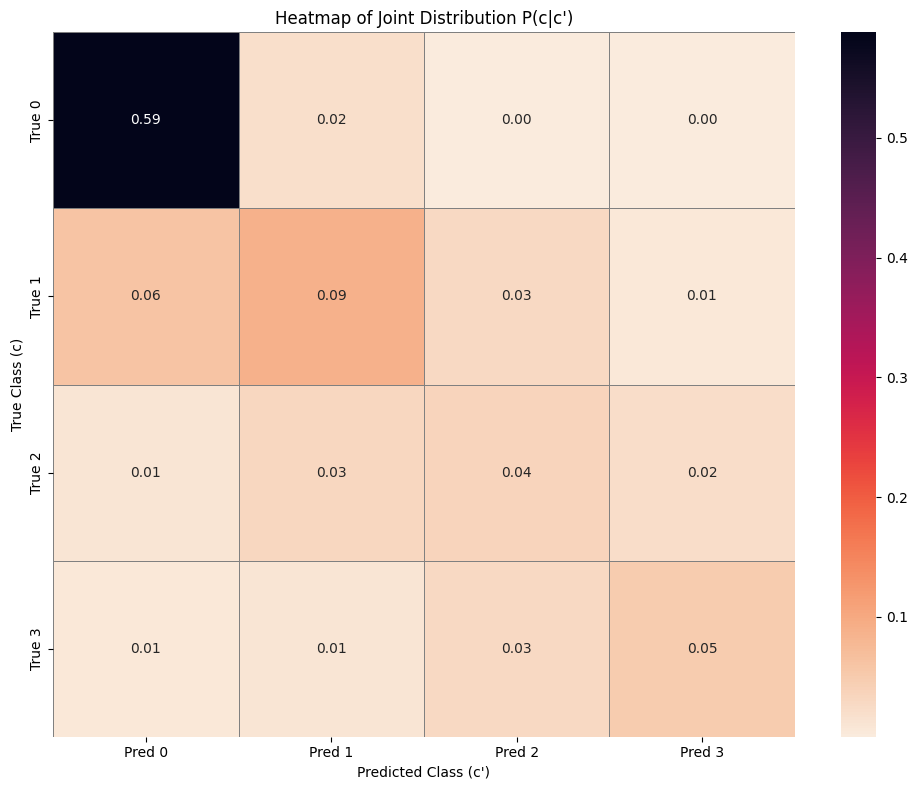

In [79]:
evaluator.plot_heatmap()

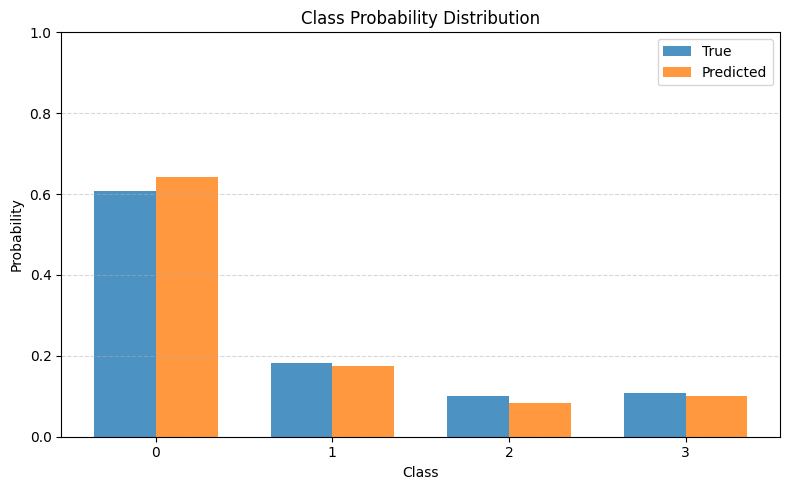

{'true_probs': {np.float64(0.0): np.float64(0.6083333333333333),
  np.float64(1.0): np.float64(0.18333333333333332),
  np.float64(2.0): np.float64(0.1),
  np.float64(3.0): np.float64(0.10833333333333334)},
 'pred_probs': {np.float64(0.0): np.float64(0.6416666666666667),
  np.float64(1.0): np.float64(0.175),
  np.float64(2.0): np.float64(0.08333333333333333),
  np.float64(3.0): np.float64(0.1)}}

In [83]:
evaluator.plot_class_distribution()

In [253]:
# Compare distributions statistically
p_val, true_dist, pred_dist = evaluator.compare_class_distributions()
print(f"Chi-square test p-value: {p_val:.4f}")
if p_val < 0.05:
    print("Distributions are significantly different.")
else:
    print("No significant difference between distributions.")


Chi-square test p-value: 0.8791
No significant difference between distributions.


D=1 | MEAN-AUC-ROC: 0.503 ± 0.014 | MEAN-AUC-PR: 0.187 ± 0.012
D=2 | MEAN-AUC-ROC: 0.537 ± 0.059 | MEAN-AUC-PR: 0.211 ± 0.040
D=3 | MEAN-AUC-ROC: 0.587 ± 0.086 | MEAN-AUC-PR: 0.257 ± 0.084
D=4 | MEAN-AUC-ROC: 0.698 ± 0.138 | MEAN-AUC-PR: 0.399 ± 0.170
D=5 | MEAN-AUC-ROC: 0.621 ± 0.134 | MEAN-AUC-PR: 0.304 ± 0.145
D=6 | MEAN-AUC-ROC: 0.828 ± 0.123 | MEAN-AUC-PR: 0.594 ± 0.201
D=7 | MEAN-AUC-ROC: 0.833 ± 0.116 | MEAN-AUC-PR: 0.601 ± 0.184
D=8 | MEAN-AUC-ROC: 0.842 ± 0.157 | MEAN-AUC-PR: 0.646 ± 0.227
D=9 | MEAN-AUC-ROC: 0.871 ± 0.120 | MEAN-AUC-PR: 0.674 ± 0.183
D=10 | MEAN-AUC-ROC: 0.891 ± 0.091 | MEAN-AUC-PR: 0.707 ± 0.172
D=11 | MEAN-AUC-ROC: 0.845 ± 0.150 | MEAN-AUC-PR: 0.628 ± 0.204
D=12 | MEAN-AUC-ROC: 0.871 ± 0.143 | MEAN-AUC-PR: 0.697 ± 0.221
D=13 | MEAN-AUC-ROC: 0.909 ± 0.115 | MEAN-AUC-PR: 0.782 ± 0.176
D=14 | MEAN-AUC-ROC: 0.865 ± 0.181 | MEAN-AUC-PR: 0.736 ± 0.254
D=15 | MEAN-AUC-ROC: 0.911 ± 0.113 | MEAN-AUC-PR: 0.792 ± 0.173
D=16 | MEAN-AUC-ROC: 0.907 ± 0.112 | MEAN-AUC-PR:

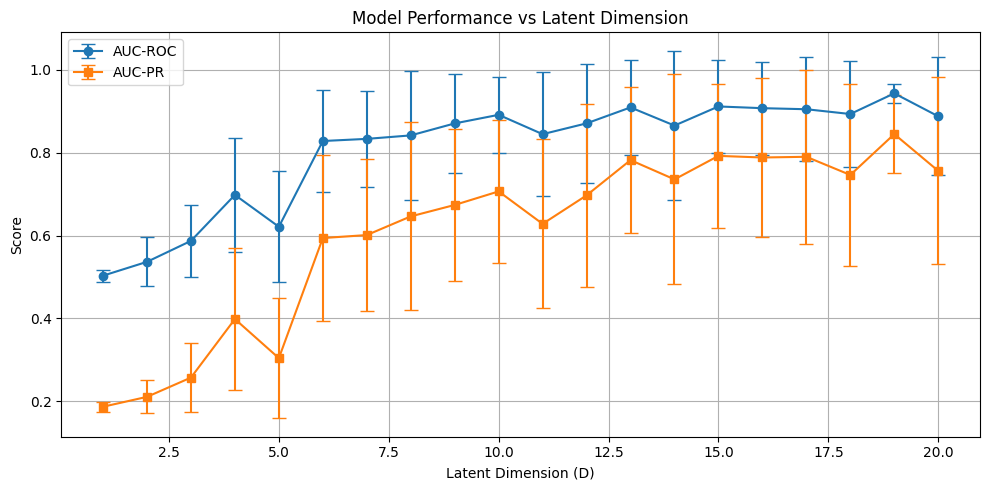

In [254]:
holdout_ratio = 0.1
results, std_aucs, std_prs = train_and_evaluate_bin(Aij, embedding_dims, device, holdout_ratio, n_epochs, lr)
plot_auc(results, std_aucs, std_prs)

In [255]:
#real data
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/Bachelor/src/data/adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([968, 3964])


In [259]:
half_rows = Aij_real.shape[0] // 2
half_cols = Aij_real.shape[1] // 2
Aij_half = Aij_real[:half_rows, :half_cols]

In [260]:
embedding_dims = [100, 200]
n_epochs = 500
lr = 0.01
seed = 20
model = LDMP(Aij_half, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss
print(loss_out)

[6.311312198638916, 5.9054341316223145, 5.502433776855469, 5.1310014724731445, 4.833670616149902, 4.521702766418457, 4.179742336273193, 3.8734211921691895, 3.5669822692871094, 3.2792603969573975, 3.065504550933838, 2.8699142932891846, 2.656402826309204, 2.427616834640503, 2.2204670906066895, 2.046588897705078, 1.9110572338104248, 1.8032960891723633, 1.7116382122039795, 1.6251240968704224, 1.545393943786621, 1.4720287322998047, 1.398787260055542, 1.3295601606369019, 1.2679920196533203, 1.2130656242370605, 1.1630916595458984, 1.1169856786727905, 1.073732852935791, 1.0323799848556519, 0.9931305646896362, 0.9557629227638245, 0.9205954670906067, 0.887740969657898, 0.8571805953979492, 0.8285850286483765, 0.8012691736221313, 0.7746380567550659, 0.7483789920806885, 0.7232223153114319, 0.6998956799507141, 0.6790481209754944, 0.6607402563095093, 0.6447038054466248, 0.6307748556137085, 0.6186519265174866, 0.6079044938087463, 0.5981859564781189, 0.5892493724822998, 0.5808759927749634, 0.5728659033

ValueError: x and y must have same first dimension, but have shapes (3,) and (20,)

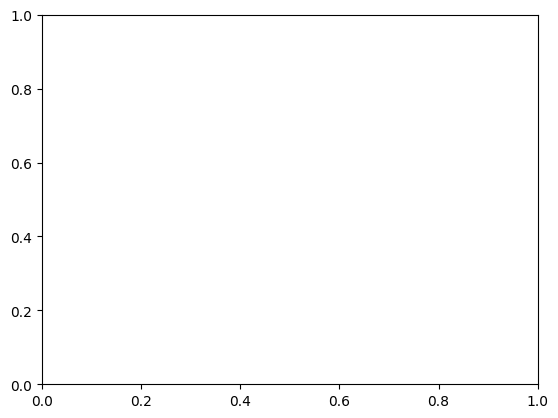

In [266]:
embedding_dims = [100, 200, 300]
holdout_ratio = 0.1
n_epochs = 300
lr = 0.01
#results, std_aucs, std_prs = train_and_evaluate_simple(Aij_half, embedding_dims, device, holdout_ratio, n_epochs, lr)
results, class_acc_dict = train_and_evaluate_simple(Aij_half, embedding_dims, device, holdout_ratio, n_epochs, lr)

#plot_class_accuracy(embedding_dims, accs)

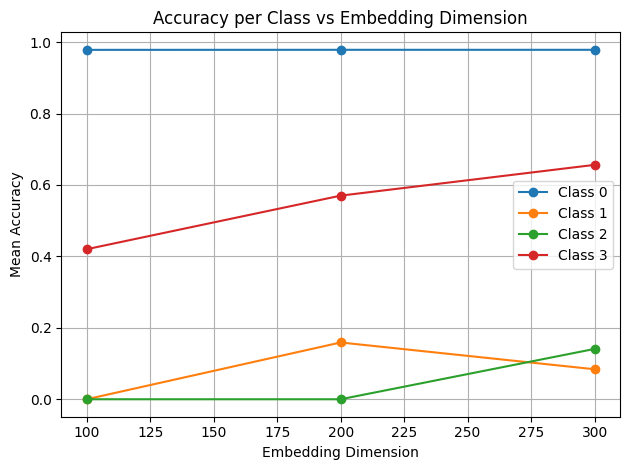

In [267]:
plot_class_accuracy(embedding_dims, class_acc_dict)

In [303]:
#given new drug
def infer_new_drug(model, new_row_tensor, n_iters=1000, lr=0.01):
    """
    Given a new drug's side effect vector (1D tensor), optimize its embedding w_new.
    """
    w_new = torch.randn((1, model.w.shape[1]), requires_grad=True, device=model.device)
    optimizer = torch.optim.Adam([w_new], lr=lr)

    v = model.v.detach()  # Existing side effect embeddings
    beta = model.beta.detach()
    thresholds = model.get_thresholds().detach()

    normal_dist = Normal(0, 1)
    target = new_row_tensor.to(model.device)

    for _ in range(n_iters):
        optimizer.zero_grad()

        dist = -torch.norm(w_new.unsqueeze(1) - v.unsqueeze(0), dim=2)  # shape: (1, n_effects)
        linear_term = torch.matmul(target, beta.unsqueeze(1))  # optional if side info exists
        latent_var = linear_term + dist

        prob = []
        for y in range(model.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            prob.append(normal_dist.cdf(z1) - normal_dist.cdf(z2))
        prob = torch.stack(prob)         # shape: (n_classes, n_effects, 1)
        prob = prob.squeeze(-1).T 

        one_hot_target = torch.nn.functional.one_hot(target.long(), num_classes=model.n_ordinal_classes)
        loss = -torch.mean(torch.sum(torch.log(prob + 1e-8) * one_hot_target, dim=1))

        loss.backward()
        optimizer.step()

    return w_new.detach()

def predict_links_for_new_drug(model, w_new):
    v = model.v.detach()
    beta = model.beta.detach()
    thresholds = model.get_thresholds().detach()
    normal_dist = Normal(0, 1)

    dist = -torch.norm(w_new.unsqueeze(1) - v.unsqueeze(0), dim=2)  # shape (1, n_effects)
    linear_term = torch.matmul(torch.ones_like(dist), beta.unsqueeze(1))  # broadcasted
    latent_var = linear_term + dist

    prob = []
    for y in range(model.n_ordinal_classes):
        z1 = latent_var - thresholds[y]
        z2 = latent_var - thresholds[y+1]
        prob.append(normal_dist.cdf(z1) - normal_dist.cdf(z2))

    prob = torch.stack(prob)         # shape: (n_classes, n_effects, 1)
    prob = prob.squeeze(-1).T 
    predicted_categories = torch.argmax(prob, dim=2)
    return predicted_categories, prob


### Predicting

In [308]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
embedding_dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 300
lr = 0.01
seed = 20
model = LDMP(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss
print(loss_out)

[7.055840969085693, 7.043365478515625, 7.019913673400879, 6.996788024902344, 6.969350337982178, 6.955492973327637, 6.904437065124512, 6.867269039154053, 6.822094917297363, 6.785559177398682, 6.723251819610596, 6.679030418395996, 6.629278182983398, 6.576092720031738, 6.526769638061523, 6.465520858764648, 6.4178080558776855, 6.35983943939209, 6.302857875823975, 6.254734992980957, 6.18934965133667, 6.139443397521973, 6.085845947265625, 6.0323662757873535, 5.981603622436523, 5.9214701652526855, 5.863337516784668, 5.809304237365723, 5.739535331726074, 5.683229923248291, 5.626917839050293, 5.572146415710449, 5.517123699188232, 5.4659199714660645, 5.41731595993042, 5.360161781311035, 5.313021659851074, 5.2666754722595215, 5.211048603057861, 5.169897079467773, 5.112143039703369, 5.052041530609131, 4.981412410736084, 4.915080547332764, 4.828273296356201, 4.735598564147949, 4.6462578773498535, 4.511855125427246, 4.389016151428223, 4.23411750793457, 4.0635666847229, 3.909095287322998, 3.739951372

In [302]:
Aij[2]

tensor([3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.])

In [304]:
model.eval()

# Select a new drug row (e.g., row 300)
new_row_tensor = Aij[2]  # shape: (n_effects,)

# Call the inference function
w_new = infer_new_drug(model, new_row_tensor)

# Optionally: predict links for the new drug
predicted_categories, probabilities = predict_links_for_new_drug(model, w_new)

print(predicted_categories, probabilities) 

tensor([[2],
        [3],
        [2],
        [2],
        [2],
        [3],
        [2],
        [2],
        [2],
        [1],
        [2],
        [2]]) tensor([[[0.0000e+00, 5.4836e-06, 9.5139e-01, 4.8600e-02]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4392e-03]],

        [[0.0000e+00, 1.3113e-06, 9.1286e-01, 8.7134e-02]],

        [[0.0000e+00, 5.9605e-08, 7.7735e-01, 2.2265e-01]],

        [[0.0000e+00, 2.9802e-06, 9.3647e-01, 6.3525e-02]],

        [[0.0000e+00, 0.0000e+00, 7.6839e-03, 9.9222e-01]],

        [[0.0000e+00, 3.5763e-07, 8.6599e-01, 1.3401e-01]],

        [[0.0000e+00, 1.8120e-05, 9.7278e-01, 2.7200e-02]],

        [[0.0000e+00, 0.0000e+00, 6.5306e-01, 3.4694e-01]],

        [[1.0210e-03, 9.9856e-01, 4.2132e-04, 0.0000e+00]],

        [[0.0000e+00, 1.1921e-07, 8.1925e-01, 1.8075e-01]],

        [[0.0000e+00, 2.3842e-07, 8.5117e-01, 1.4883e-01]]])


In [305]:
w_new

tensor([[ 1.6323, -0.9918, -4.0504,  2.0367,  0.9652,  2.2614,  1.5151,  1.4690,
         -3.4981, -1.0536, -2.3704,  1.2264, -0.0073, -1.4755,  3.9672,  1.0415,
         -2.4118]])

In [333]:
def embed_new_drug(trained_model, Aij_new_row, n_epochs=400, lr=0.01):
    """
    Use a trained LDM model to embed a new drug given its row of side effect associations.

    Args:
        trained_model (LDM): The trained LDM model.
        Aij_new_row (torch.Tensor): 1D tensor (num_effects,) of ordinal side effect levels for the new drug.
        n_epochs (int): Training steps for optimizing new embedding.
        lr (float): Learning rate for optimizer.

    Returns:
        w_new (torch.Tensor): Learned latent vector for the new drug.
        predicted_probs (torch.Tensor): (num_effects, ordinal_classes) probabilities for each side effect.
        predicted_categories (torch.Tensor): (num_effects,) predicted category for each side effect.
    """
    trained_model.eval()  # set to inference mode

    device = trained_model.device
    embedding_dim = trained_model.w.shape[1]
    n_effects = trained_model.v.shape[0]
    n_classes = trained_model.n_ordinal_classes

    # Freeze model parameters
    for param in trained_model.parameters():
        param.requires_grad = False

    # Initialize new latent drug embedding
    w_new = torch.randn(1, embedding_dim, requires_grad=True, device=device)

    # Optimizer for new drug embedding only
    optimizer = torch.optim.Adam([w_new], lr=lr)

    # Create new Aij (1 × n_effects)
    Aij_new = Aij_new_row.to(device).unsqueeze(0)  # shape (1, n_effects)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Linear + Distance term
        linear_term = torch.matmul(Aij_new, trained_model.beta.unsqueeze(1))  # (1 × 1)
        dist = -torch.norm(w_new.unsqueeze(1) - trained_model.v.unsqueeze(0), dim=2)  # (1 × n_effects)
        latent_var = linear_term + dist  # (1 × n_effects)

        thresholds = trained_model.get_thresholds()  # (n_classes+1)
        normal_dist = Normal(0, 1)

        prob = torch.zeros((n_classes, 1, n_effects), device=device)
        for y in range(n_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            prob[y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)

        # Compute loss
        one_hot_target = torch.zeros(1, n_effects, n_classes, device=device)
        one_hot_target.scatter_(-1, Aij_new.unsqueeze(-1).long(), 1)

        loss = -torch.mean(torch.log(torch.sum(prob.permute(1, 2, 0) * one_hot_target, dim=-1) + 1e-8))
        loss.backward()
        optimizer.step()

    # Final prediction
    final_latent_var = torch.matmul(Aij_new, trained_model.beta.unsqueeze(1)) + \
                       -torch.norm(w_new.unsqueeze(1) - trained_model.v.unsqueeze(0), dim=2)
    
    final_prob = torch.zeros((n_classes, 1, n_effects), device=device)
    thresholds = trained_model.get_thresholds()
    for y in range(n_classes):
        z1 = final_latent_var - thresholds[y]
        z2 = final_latent_var - thresholds[y+1]
        final_prob[y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)

    probs = final_prob.squeeze(1).permute(1, 0)  # (n_effects, n_classes)
    categories = torch.argmax(probs, dim=-1)

    return w_new.detach(), probs, categories

embedding_dim = 35
n_epochs = 500

model = LDMP(Aij, embedding_dim, device, n_epochs, lr, seed)
new_drug_row = torch.tensor([0, 2, 1, 0, 3, 0, 0, 0, 1, 2, 0, 0], dtype=torch.float32)  # ordinal side effect values for new drug
w_new, probs, cats = embed_new_drug(trained_model=model, Aij_new_row=new_drug_row)

print("New drug embedding:", w_new)
print("Predicted side effect probs:", probs)
print("Predicted categories:", cats)
print("Real categories:", new_drug_row)

New drug embedding: tensor([[-1.6513, -0.8546,  0.3647,  1.3052,  1.1606,  0.2806, -3.1205, -0.1856,
         -1.9416,  1.5939, -1.5548,  2.0015,  0.4750, -1.2615,  1.7695, -1.4064,
          2.2540, -1.3977,  0.1609,  0.0549, -1.4050, -1.6426,  0.3807,  1.2206,
         -1.7115, -0.3114,  0.1288,  1.7417, -0.5660, -1.0309, -0.4192,  2.1022,
         -0.7140,  1.4871,  0.2518]])
Predicted side effect probs: tensor([[8.1164e-01, 1.8576e-01, 2.5760e-03, 1.5080e-05],
        [1.4394e-01, 6.5805e-01, 1.8500e-01, 1.2935e-02],
        [1.2489e-01, 6.5167e-01, 2.0716e-01, 1.6156e-02],
        [6.1549e-01, 3.7079e-01, 1.3550e-02, 1.7035e-04],
        [2.8819e-04, 6.2596e-02, 3.7586e-01, 4.7659e-01],
        [6.0822e-01, 3.7738e-01, 1.4216e-02, 1.8314e-04],
        [1.0000e+00, 2.9802e-08, 0.0000e+00, 0.0000e+00],
        [7.3674e-01, 2.5779e-01, 5.4221e-03, 4.3958e-05],
        [3.3340e-01, 5.9730e-01, 6.7174e-02, 2.1271e-03],
        [1.3888e-02, 3.7244e-01, 4.7536e-01, 1.3387e-01],
        [